In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_sentiment.csv',
              header=None,index_col=0)
df.head()

,1,2,3
0,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df=df[[2,3]].reset_index(drop=True)

In [4]:
df.columns=['sentiment','text']
df.head(3)

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


In [5]:
df.isnull().sum()
df.dropna(inplace=True)

In [6]:
sum(df['text'].apply(len)>5),sum(df['text'].apply(len)<=5)

(72883, 2113)

In [7]:
print(df.shape)
df=df[df['text'].apply(len)>5]
print(df.shape)

(74996, 2)
(72883, 2)


In [8]:
df['sentiment'].value_counts()

sentiment
Negative      22020
Positive      20186
Neutral       17899
Irrelevant    12778
Name: count, dtype: int64

In [9]:
import preprocess_kgptalkie as ps
df.columns

Index(['sentiment', 'text'], dtype='object')

In [10]:
df=ps.get_basic_features(df)

In [11]:
df.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

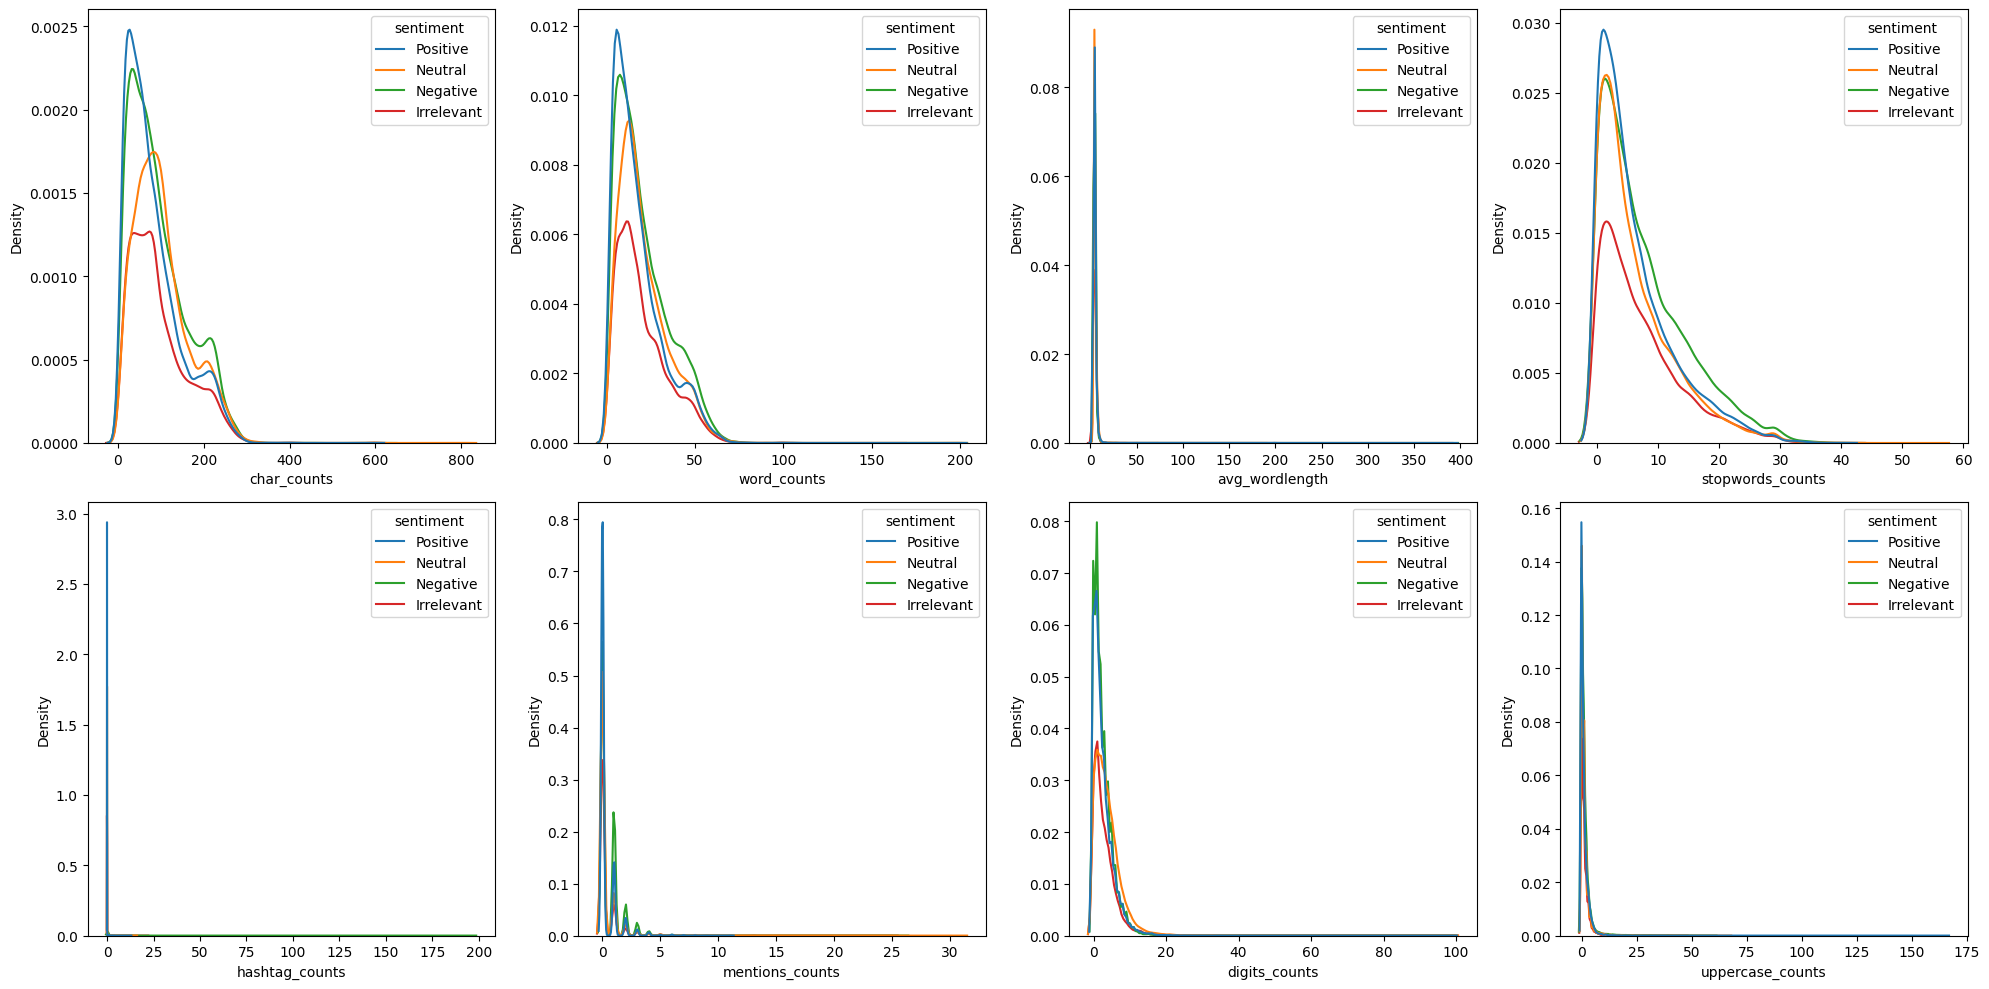

In [12]:
 import matplotlib.pyplot as plt
import seaborn as sns

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for index,col in enumerate(num_cols):
    plt.subplot(2,4,index+1)
    sns.kdeplot(data=df, x=col,hue="sentiment")
plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

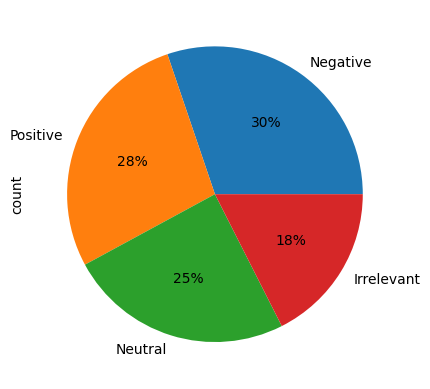

In [13]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')


In [14]:
from wordcloud import WordCloud,STOPWORDS
stopwords=set(STOPWORDS)

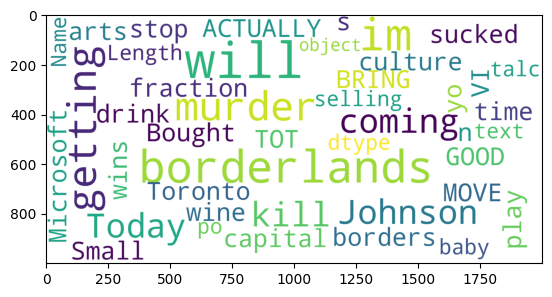

In [15]:
wordcloud=WordCloud(background_color='white',stopwords=stopwords,max_words=300,max_font_size=40,scale=5).generate(
    str(df['text']))
plt.imshow(wordcloud)

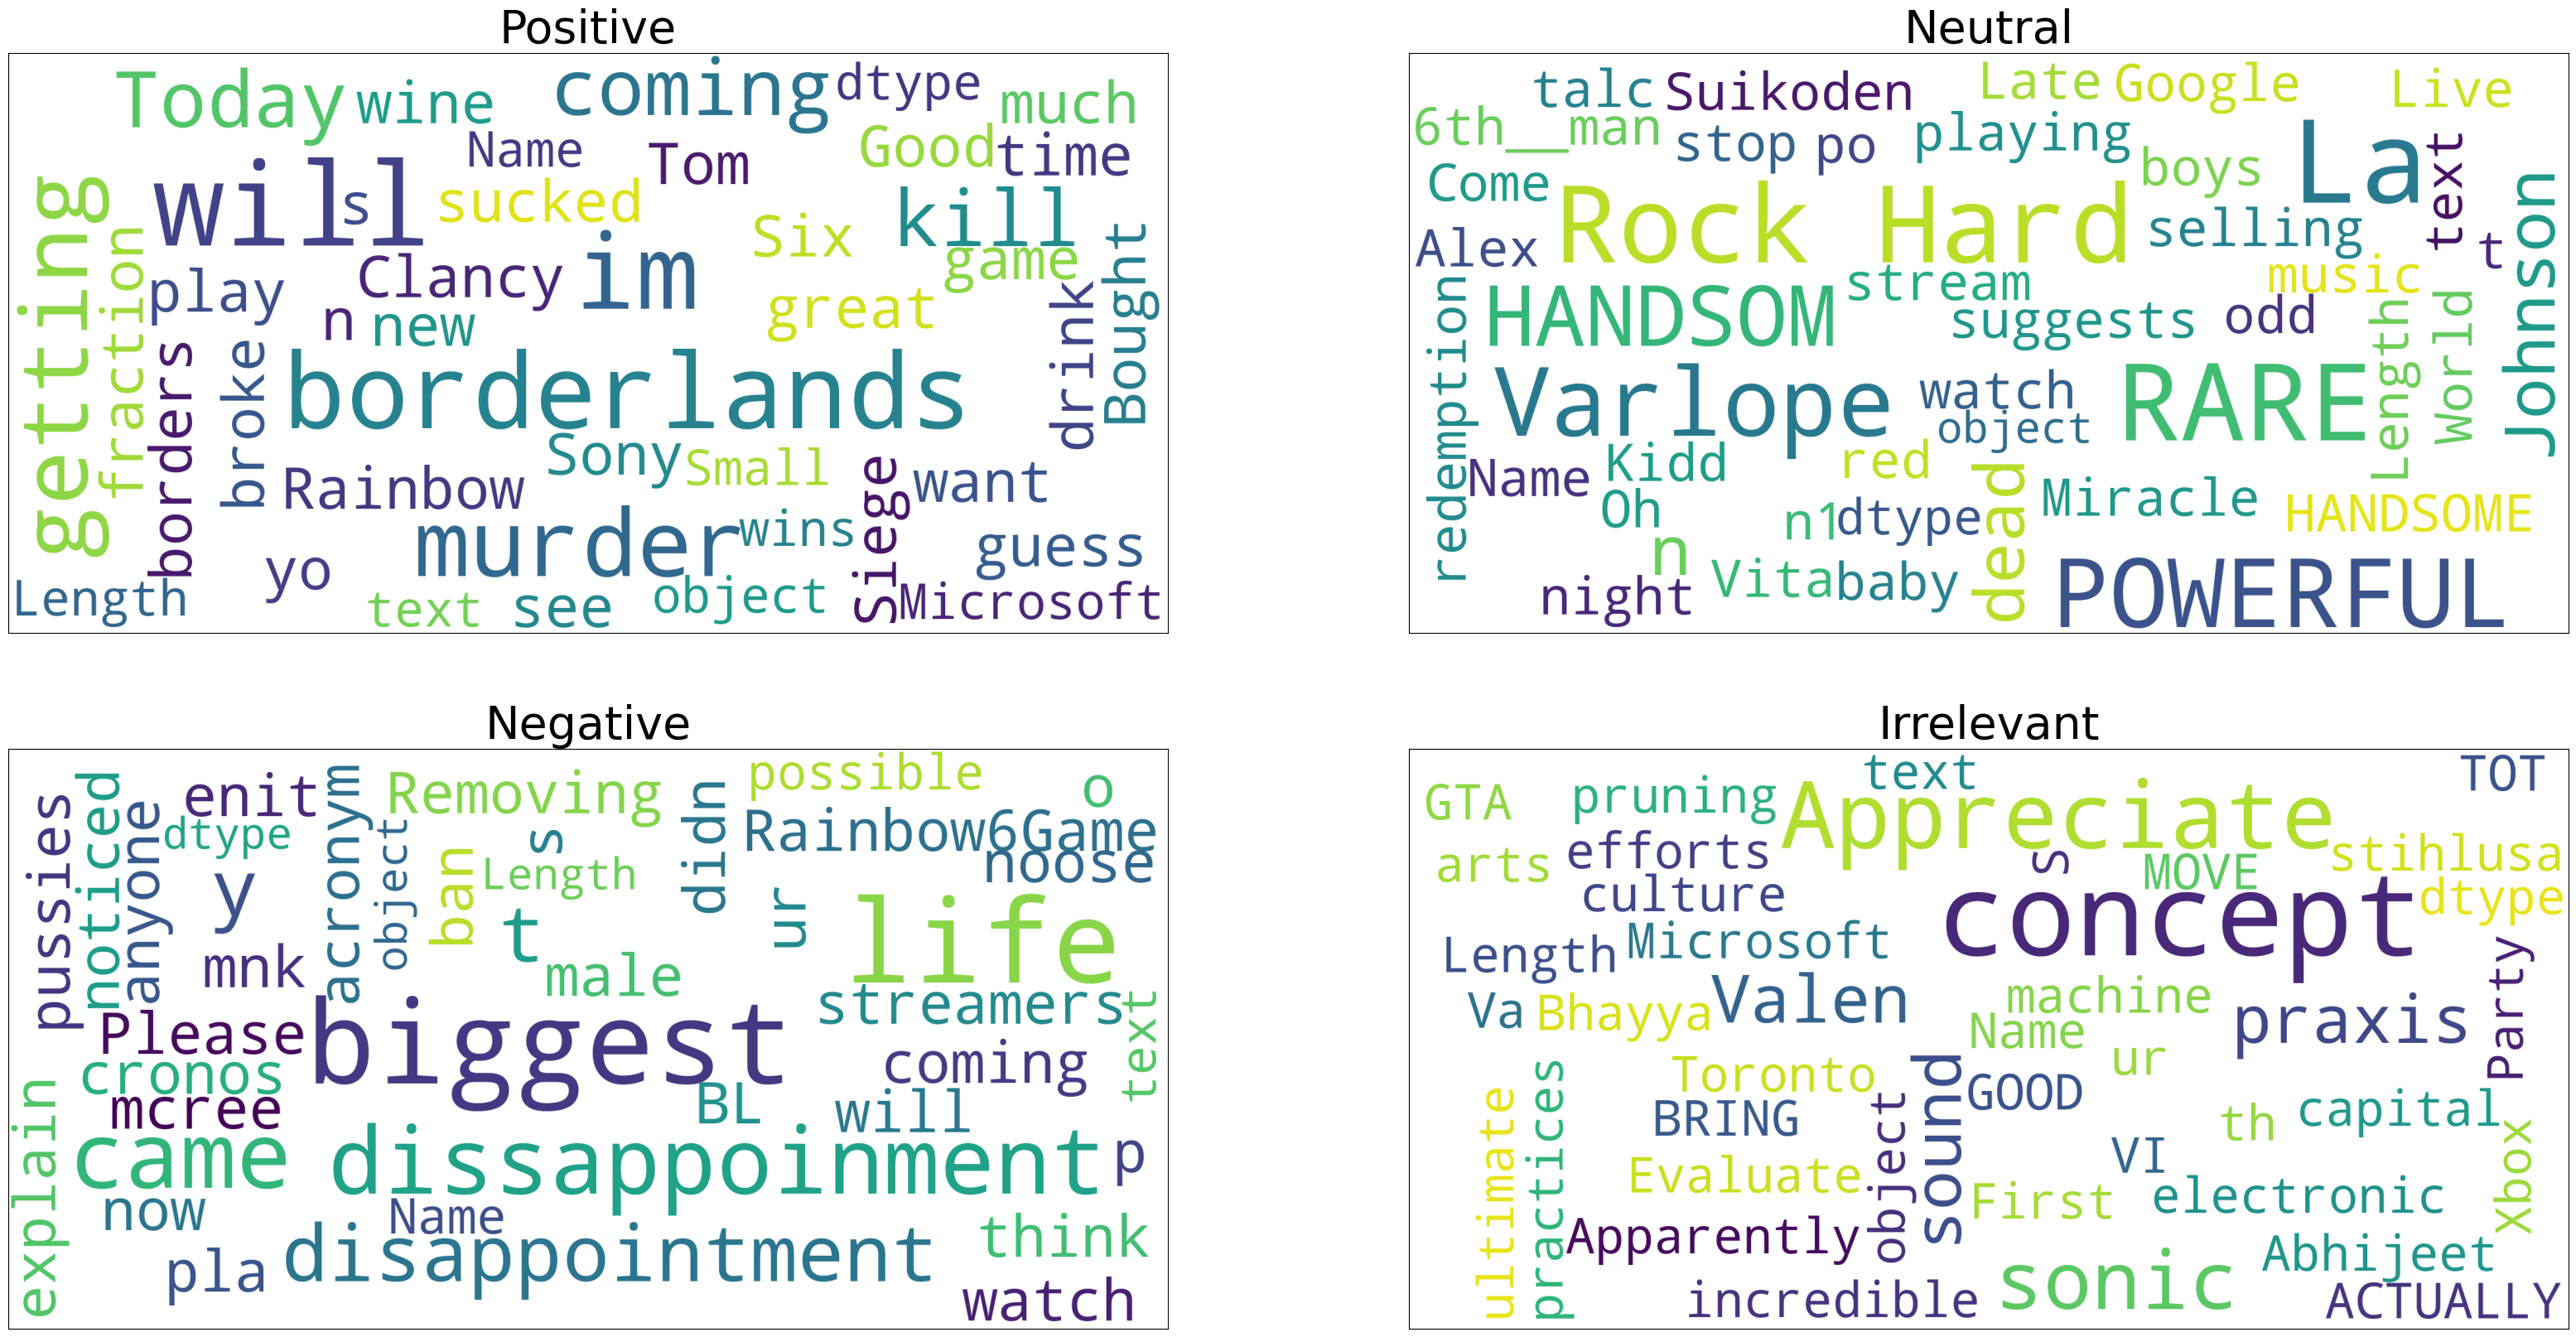

In [16]:
plt.figure(figsize=(40,20))

for index, sent in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    data = df[df['sentiment']==sent]['text']

    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(sent, fontsize=40)
    


In [17]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=0)

In [19]:
X_train.shape, X_test.shape

((58306,), (14577,))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


In [22]:
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [23]:
from sklearn.metrics import classification_report

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.85      0.91      2561
    Negative       0.92      0.96      0.94      4481
     Neutral       0.93      0.92      0.92      3553
    Positive       0.90      0.95      0.92      3982

    accuracy                           0.93     14577
   macro avg       0.93      0.92      0.92     14577
weighted avg       0.93      0.93      0.92     14577



In [24]:
clf.predict(['i do not like you'])

array(['Negative'], dtype=object)

In [27]:
clf.predict(['i am so happy to see you'])

array(['Positive'], dtype=object)

In [28]:
clf.predict(['got a job at microsoft'])

array(['Neutral'], dtype=object)

In [29]:
clf.predict(['how the hell are we in halloween month already'])

array(['Irrelevant'], dtype=object)

In [26]:
import pickle

pickle.dump(clf, open('twitter_sentiment.pkl', 'wb'))